# SQLAlchemy + pandas — Midterm

This notebook shows patterns for using SQLAlchemy with pandas:

- Connect to a database (SQLite)
- Write and read tables using pandas (`to_sql`, `read_sql`)
- Run simple SQL queries for analysis
- Clean and subset the Spotify dataset for fast demos
- Answer business questions (genres, artists, danceability, explicit, tempo)
- Advanced: make a tiny `artists_dim` and JOIN; show a transaction + rollback

## Part 1 — Quick Start in 3 Steps

In [1]:
#Installing SQLAlchemy
!pip install sqlalchemy pandas matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from sqlalchemy import create_engine
import pandas as pd

# Step 1: Connect (creates demo.db if it doesn't exist)
engine = create_engine('sqlite:///demo.db')

# Step 2: Create and insert a tiny table from pandas
df = pd.DataFrame({'id':[1,2,3], 'name':['Abby','Ben','Cathy']})
df.to_sql('users', engine, if_exists='replace', index=False)

# Step 3: Read the data back to pandas
users = pd.read_sql('SELECT * FROM users', engine)
users

,id,name
0,1,Abby
1,2,Ben
2,3,Cathy


### Add more data, filter, and sort

In [5]:
# Append a row
pd.DataFrame({'id':[4], 'name':['Dylan']}).to_sql('users', engine, if_exists='append', index=False)

# Filter & sort with SQL
subset = pd.read_sql('SELECT * FROM users WHERE id > 2 ORDER BY id DESC', engine)
subset

,id,name
0,4,Dylan
1,3,Cathy


### Update and delete (tiny SQL via SQLAlchemy)

In [7]:
from sqlalchemy import text

with engine.begin() as conn:
    conn.execute(text("UPDATE users SET name='Vans' WHERE id=1"))
    conn.execute(text('DELETE FROM users WHERE id=4'))

pd.read_sql('SELECT * FROM users', engine)

,id,name
0,1,Vans
1,2,Ben
2,3,Cathy


## Part 2 — Spotify Dataset

We will:
1. Load `dataset.csv`
2. Save to a table `spotify_data`
3. Create a fast subset `top_songs` (10k most popular)
4. Answer business questions with tiny SQL queries

In [9]:
from sqlalchemy import create_engine, text
import os, zipfile, pandas as pd

# Use a separate DB file for project data
engine = create_engine('sqlite:///data/spotify.db')
os.makedirs('data', exist_ok=True)

# Try to ensure dataset.csv exists in ./data
csv_path = 'data/dataset.csv'
if (not os.path.exists(csv_path)) and os.path.exists('/mnt/data/dataset.csv.zip'):
    with zipfile.ZipFile('/mnt/data/dataset.csv.zip') as zf:
        zf.extract('dataset.csv', path='data')

# Load CSV -> database table
spotify = pd.read_csv(csv_path)
spotify.to_sql('spotify_data', engine, if_exists='replace', index=False)

pd.read_sql('SELECT * FROM spotify_data LIMIT 5', engine)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,0,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


### Create a fast subset `top_songs` (10k most popular)

In [11]:
create_top = (
    'CREATE TABLE top_songs AS\n'
    'SELECT\n'
    '  track_name, artists, track_genre, popularity,\n'
    '  danceability, tempo, explicit, duration_ms,\n'
    '  energy, valence, liveness, acousticness, speechiness, instrumentalness\n'
    'FROM spotify_data\n'
    'WHERE popularity IS NOT NULL\n'
    'ORDER BY popularity DESC\n'
    'LIMIT 10000'
)
with engine.begin() as conn:
    conn.execute(text('DROP TABLE IF EXISTS top_songs'))
    conn.execute(text(create_top))

pd.read_sql('SELECT * FROM top_songs LIMIT 5', engine)

,track_name,artists,track_genre,popularity,danceability,tempo,explicit,duration_ms,energy,valence,liveness,acousticness,speechiness,instrumentalness
0,Unholy (feat. Kim Petras),Sam Smith;Kim Petras,dance,100,0.714,131.121,0,156943,0.472,0.238,0.266,0.01300,0.0864,0.000005
1,Unholy (feat. Kim Petras),Sam Smith;Kim Petras,pop,100,0.714,131.121,0,156943,0.472,0.238,0.266,0.01300,0.0864,0.000005
2,"Quevedo: Bzrp Music Sessions, Vol. 52",Bizarrap;Quevedo,hip-hop,99,0.621,128.033,0,198937,0.782,0.550,0.230,0.01250,0.0440,0.033000
3,I'm Good (Blue),David Guetta;Bebe Rexha,dance,98,0.561,128.040,1,175238,0.965,0.304,0.371,0.00383,0.0343,0.000007
4,I'm Good (Blue),David Guetta;Bebe Rexha,edm,98,0.561,128.040,1,175238,0.965,0.304,0.371,0.00383,0.0343,0.000007


## Part 3 — Business Questions (Simple SQL)

### Q1) Which genres are most popular on average?

In [13]:
q1 = (
    'SELECT track_genre, AVG(popularity) AS avg_popularity, COUNT(*) AS n\n'
    'FROM top_songs\n'
    'WHERE track_genre IS NOT NULL\n'
    'GROUP BY track_genre\n'
    'ORDER BY avg_popularity DESC\n'
    'LIMIT 10'
)
top_genres = pd.read_sql(q1, engine)
top_genres

,track_genre,avg_popularity,n
0,rock,78.650943,212
1,dance,77.822878,271
2,latino,77.326923,208
3,chicago-house,77.000000,2
4,reggaeton,76.953125,192
5,reggae,76.893939,132
6,latin,76.873239,71
7,indie,74.514056,249
8,ska,74.166667,12
9,funk,73.519608,102


### Q2) Which artists are most consistent (>= 5 tracks)?

In [15]:
q2 = (
    'SELECT artists, COUNT(*) AS num_songs, AVG(popularity) AS avg_popularity\n'
    'FROM top_songs\n'
    'GROUP BY artists\n'
    'HAVING num_songs >= 5\n'
    'ORDER BY avg_popularity DESC\n'
    'LIMIT 10'
)
consistent_artists = pd.read_sql(q2, engine)
consistent_artists

,artists,num_songs,avg_popularity
0,The Weeknd,5,89.000000
1,Calvin Harris;Dua Lipa,5,89.000000
2,Olivia Rodrigo,5,87.400000
3,Bad Bunny,48,87.083333
4,Bad Bunny;Jhayco,8,87.000000
5,Marshmello;Jonas Brothers,5,85.000000
6,J Balvin;Bad Bunny,6,84.500000
7,Doja Cat,8,84.375000
8,The Chainsmokers;Halsey,5,84.000000
9,Marshmello;Khalid,10,84.000000


### Q3) Does danceability affect popularity? (bin to 0.1)

In [17]:
q3 = (
    'SELECT ROUND(danceability, 1) AS dance_score, AVG(popularity) AS avg_popularity, COUNT(*) AS n\n'
    'FROM top_songs\n'
    'WHERE danceability IS NOT NULL\n'
    'GROUP BY dance_score\n'
    'ORDER BY dance_score'
)
dance_pop = pd.read_sql(q3, engine)
dance_pop

,dance_score,avg_popularity,n
0,0.0,75.000000,3
1,0.1,68.531250,32
2,0.2,69.168919,148
3,0.3,70.483645,428
4,0.4,71.025768,1009
5,0.5,70.970222,1847
6,0.6,71.591179,2358
7,0.7,71.708421,2387
8,0.8,72.949466,1405
9,0.9,73.861413,368


### Q4) Are explicit songs more popular on average?

In [19]:
q4 = (
    'SELECT explicit, AVG(popularity) AS avg_popularity, COUNT(*) AS n\n'
    'FROM top_songs\n'
    'GROUP BY explicit\n'
    'ORDER BY avg_popularity DESC'
)
explicit_stats = pd.read_sql(q4, engine)
explicit_stats

,explicit,avg_popularity,n
0,1,73.158840,1448
1,0,71.366932,8552


### Q5) What tempo ranges (BPM) perform best? (bin to nearest 10)

In [21]:
q5 = (
    'SELECT ROUND(tempo/10)*10 AS tempo_range, AVG(popularity) AS avg_popularity, COUNT(*) AS n\n'
    'FROM top_songs\n'
    'WHERE tempo IS NOT NULL\n'
    'GROUP BY tempo_range\n'
    'ORDER BY avg_popularity DESC\n'
    'LIMIT 10'
)
tempo_pop = pd.read_sql(q5, engine)
tempo_pop

,tempo_range,avg_popularity,n
0,50.0,77.500000,2
1,0.0,75.000000,3
2,120.0,72.231114,1562
3,180.0,71.983333,300
4,100.0,71.974535,1453
5,110.0,71.966395,982
6,90.0,71.732580,1062
7,170.0,71.656904,478
8,130.0,71.647612,1277
9,210.0,71.600000,10


### Quick visualization: Top genres by avg popularity

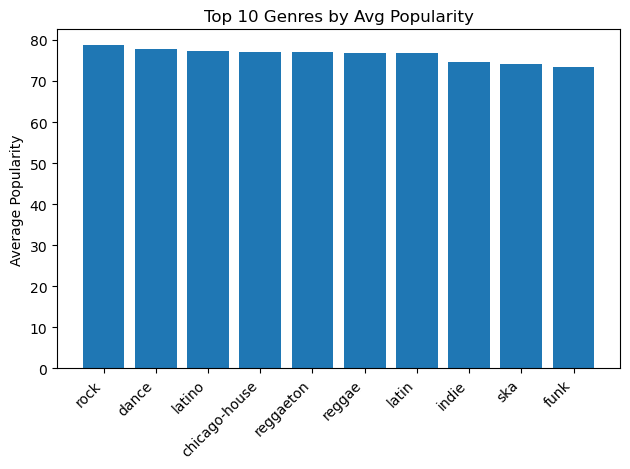

In [23]:
import matplotlib.pyplot as plt

if not top_genres.empty:
    plt.figure()
    plt.bar(top_genres['track_genre'], top_genres['avg_popularity'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Genres by Avg Popularity')
    plt.ylabel('Average Popularity')
    plt.tight_layout()
else:
    print("Run Q1 first to populate 'top_genres'.")

### Save a result table back into the database

In [25]:
top_genres.to_sql('genre_summary', engine, if_exists='replace', index=False)
pd.read_sql('SELECT * FROM genre_summary', engine).head()

,track_genre,avg_popularity,n
0,rock,78.650943,212
1,dance,77.822878,271
2,latino,77.326923,208
3,chicago-house,77.000000,2
4,reggaeton,76.953125,192


## Part 4 — Advanced: JOIN with a tiny artists table
I'll create a very small **artists_dim** table (distinct artist names) from `top_songs` and **JOIN** it for per-artist stats.

In [27]:
with engine.begin() as conn:
    conn.execute(text('DROP TABLE IF EXISTS artists_dim'))
    conn.execute(text(
        'CREATE TABLE artists_dim AS\n'
        'SELECT DISTINCT TRIM(artists) AS artist_name\n'
        'FROM top_songs\n'
        'WHERE artists IS NOT NULL'
    ))
    conn.execute(text(
        'CREATE TABLE tmp AS\n'
        'SELECT ROW_NUMBER() OVER () AS artist_id, * FROM artists_dim'
    ))
    conn.execute(text('DROP TABLE artists_dim'))
    conn.execute(text('ALTER TABLE tmp RENAME TO artists_dim'))
    conn.execute(text('CREATE UNIQUE INDEX IF NOT EXISTS ux_artist_name ON artists_dim(artist_name)'))

join_q = (
    'SELECT a.artist_name,\n'
    '       COUNT(t.track_name) AS num_tracks,\n'
    '       AVG(t.popularity) AS avg_popularity\n'
    'FROM artists_dim a\n'
    'JOIN top_songs t\n'
    '  ON t.artists = a.artist_name\n'
    'GROUP BY a.artist_name\n'
    'HAVING COUNT(t.track_name) >= 5\n'
    'ORDER BY avg_popularity DESC\n'
    'LIMIT 10'
)
top_by_join = pd.read_sql(join_q, engine)
top_by_join

,artist_name,num_tracks,avg_popularity
0,The Weeknd,5,89.000000
1,Calvin Harris;Dua Lipa,5,89.000000
2,Olivia Rodrigo,5,87.400000
3,Bad Bunny,48,87.083333
4,Bad Bunny;Jhayco,8,87.000000
5,Marshmello;Jonas Brothers,5,85.000000
6,J Balvin;Bad Bunny,6,84.500000
7,Doja Cat,8,84.375000
8,The Chainsmokers;Halsey,5,84.000000
9,Marshmello;Khalid,10,84.000000
